In [171]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [172]:
def generate_data(a, b, num_train=4000, num_test=1000):
    """生成线性分类数据集"""
    # 生成随机点
    x_train = torch.rand(num_train) * 20 - 10  # [-10, 10]
    y_train = torch.rand(num_train) * 20 - 10
    
    x_test = torch.rand(num_test) * 20 - 10
    y_test = torch.rand(num_test) * 20 - 10
    
    # 确定颜色 (直线上方为红色，标签记为1，下方或正好在线上为蓝色，标签记为0)
    # 通过zip(x_train, y_train)方式把合成(x,y)
    train_colors = torch.tensor([1 if y > a*x + b else 0 for x, y in zip(x_train, y_train)])
    test_colors = torch.tensor([1 if y > a*x + b else 0 for x, y in zip(x_test, y_test)])
    
    # 组合训练集和测试集
    train_data = torch.stack([x_train, y_train], dim=1)
    test_data = torch.stack([x_test, y_test], dim=1)
    #print(train_data, train_colors, test_data, test_colors)
    return train_data, train_colors, test_data, test_colors

In [173]:
a = 1.14  # 斜率
b = -2.713   # 截距

In [174]:
train_data, train_labels, test_data, test_labels = generate_data(a, b)

上文中，我们的训练集和测试集都是[n,2]形状的张量
为了可视化我们的分类机效果，需要运用MatplotLib进行绘制

In [175]:
def plot_data(a, b, data, labels, show_line=True):
    #设置图表宽和高
    plt.figure(figsize=(10, 8))
    
    # 绘制数据点
    #布尔索引操作：选择所有标签为1（即直线上方）的点（通过索引对应选取）
    red_points = data[labels == 1]
    blue_points = data[labels == 0]
    
    # red_points[:, 0] 取所有行的第一列，即所有红色点的x坐标，结果是一个一维数组
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.55, label='Above Line')
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.55, label='Below Line')
    
    # 绘制答案直线
    if show_line:
        #通过torch.linspace在区间[-10,10]直接平分出100个x点，带入计算得到plot所需的x,y点集
        #因为我们生成的训练集就是[-10,10]范围的，所以我们的图当然也在这个范围
        x_line = torch.linspace(-10, 10, 100)
        y_line = a * x_line + b
        plt.plot(x_line, y_line, 'g-', linewidth=3, label=f'Answer: y={a}x+{b}')
    
    plt.title(f"Data Points ({'with' if show_line else 'without'} Answer Line)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

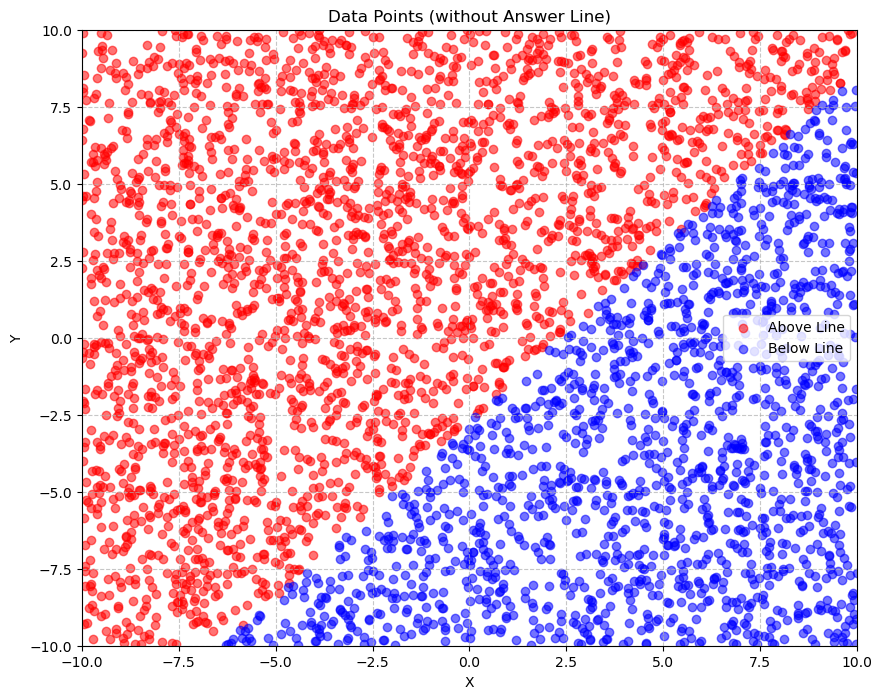

In [176]:
plot_data(a, b, train_data, train_labels, show_line=False)

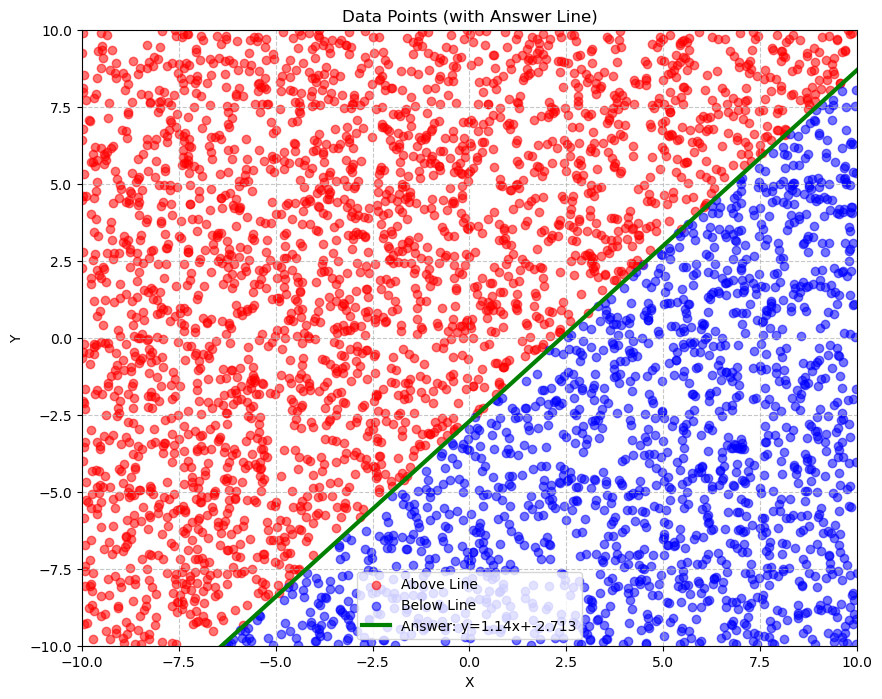

In [177]:
plot_data(a, b, train_data, train_labels, show_line=True)

In [178]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.Y_train = None
    
    def fit(self, X, Y):
        """存储训练数据"""
        self.X_train = X #点的坐标张量
        self.Y_train = Y #点的标签（0或1）张量
    
    def predict(self, X):
        """预测输入数据的类别"""
        predictions = []
        
        # 转换为张量以确保兼容性
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        
        # 批量计算距离以提高效率
        for test_point in X:
            # 计算欧氏距离
            #distances = torch.sqrt(torch.sum((self.X_train - test_point)**2, dim=1))
            # 计算曼哈顿距离
            distances = torch.sum(torch.abs(self.X_train - test_point),dim=1)
            
            '''KNN算法的核心步骤 找到最近的k个邻居'''
            # 获取最近的k个样本(largest=False: 表示选择最小而非最大的值)
            # 第一个返回值: 最小的k个距离值（用_忽略）
            _, indexes = torch.topk(distances, self.k, largest=False)
            k_nearest_labels = self.Y_train[indexes]
            
            # 统计整数张量中每个值出现的次数,投票决定类别
            counts = torch.bincount(k_nearest_labels)
            # 用torch.argmax返回张量中最大值所在的索引，item()将单元素张量转换为Python标量
            predictions.append(torch.argmax(counts).item())
        
        return torch.tensor(predictions)

In [179]:
def train_and_evaluate(K, train_data, train_labels, test_data, test_labels):
    """训练KNN模型并评估性能"""
    # 创建并训练KNN分类器
    knn = KNNClassifier(k=K)
    knn.fit(train_data, train_labels)
    
    # 预测测试集
    start_time = time.time()
    test_preds = knn.predict(test_data)
    inference_time = time.time() - start_time
    
    # 计算准确率
    if test_labels.device != test_preds.device:
        test_preds = test_preds.to(test_labels.device)
    accuracy = (test_labels == test_preds).float().mean().item()
    print(f"K={K} | 测试准确率: {accuracy:.4f} | 推理时间: {inference_time:.4f}秒")
    
    return knn, test_preds, accuracy


In [180]:
k_values = [1,2,3,4,5,7,10,13,15, 20,25]
results = {}

for k in k_values:
    knn, test_preds, accuracy = train_and_evaluate(k, train_data, train_labels, test_data, test_labels)
    results[k] = {
        'model': knn,
        'predictions': test_preds,
        'accuracy': accuracy
    }


K=1 | 测试准确率: 0.9910 | 推理时间: 0.2765秒
K=2 | 测试准确率: 0.9900 | 推理时间: 0.2915秒
K=3 | 测试准确率: 0.9900 | 推理时间: 0.2875秒
K=4 | 测试准确率: 0.9880 | 推理时间: 0.2750秒
K=5 | 测试准确率: 0.9900 | 推理时间: 0.2785秒
K=7 | 测试准确率: 0.9920 | 推理时间: 0.2780秒
K=10 | 测试准确率: 0.9900 | 推理时间: 0.2785秒
K=13 | 测试准确率: 0.9880 | 推理时间: 0.2835秒
K=15 | 测试准确率: 0.9880 | 推理时间: 0.2910秒
K=20 | 测试准确率: 0.9930 | 推理时间: 0.2910秒
K=25 | 测试准确率: 0.9930 | 推理时间: 0.2920秒


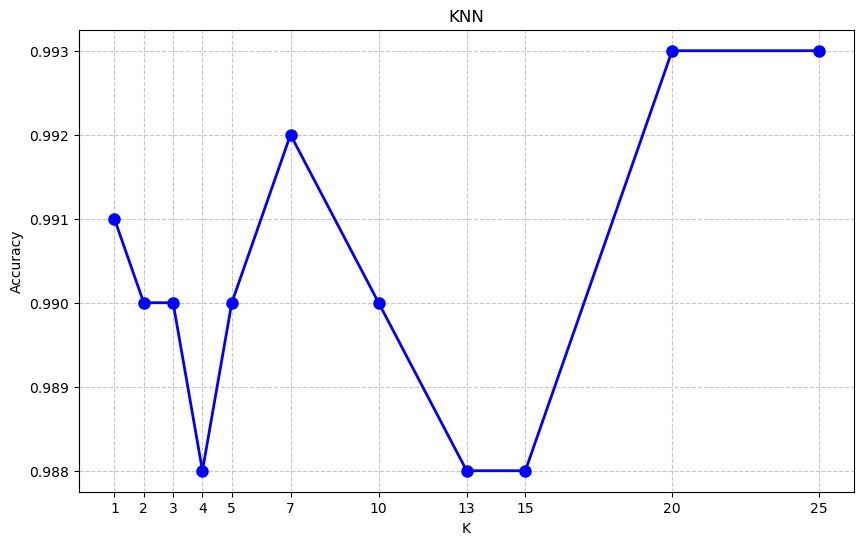

In [181]:
plt.figure(figsize=(10, 6))
accuracies = [results[k]['accuracy'] for k in k_values]
plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
plt.title('KNN')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_values)
plt.show()

In [182]:
best_k = k_values[np.argmax(accuracies)]
best_model = results[best_k]['model']
print(f"\n最佳K值: {best_k}, 准确率: {results[best_k]['accuracy']:.4f}")


最佳K值: 20, 准确率: 0.9930


In [183]:
def plot_decision_boundary(a, b, knn, data, labels):
    """可视化决策边界"""
    plt.figure(figsize=(12, 10))
    
    # 绘制数据点
    red_points = data[labels == 1]
    blue_points = data[labels == 0]
    
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, label='Above Line')
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, label='Below Line')
    
    # 绘制答案直线
    x_line = torch.linspace(-10, 10, 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, 'g-', linewidth=3, label=f'Answer: y={a}x+{b}')
    
    # 绘制KNN决策边界
    resolution = 100
    xx, yy = torch.meshgrid(torch.linspace(-10, 10, resolution), 
                           torch.linspace(-10, 10, resolution))
    grid_points = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    
    # 预测网格点的类别
    start_time = time.time()
    grid_preds = knn.predict(grid_points)
    print(f"决策边界计算时间: {time.time() - start_time:.2f}秒")
    
    # 创建决策边界图
    grid_preds = grid_preds.reshape(xx.shape)
    plt.contourf(xx, yy, grid_preds, alpha=0.2, levels=[-0.5, 0.5, 1.5], 
                colors=['blue', 'red'])
    
    # 绘制KNN近似的决策边界
    boundary_line = []
    for x in torch.linspace(-10, 10, 50):
        # 创建垂直线上的点
        y_values = torch.linspace(-10, 10, 100)
        test_points = torch.stack([torch.full_like(y_values, x), y_values], dim=1)
        
        # 预测这些点的类别
        preds = knn.predict(test_points)
        
        # 找到决策边界的位置
        diff = torch.abs(torch.diff(preds.float()))
        if torch.any(diff > 0):
            idx = torch.argmax(diff).item()
            y_boundary = (y_values[idx] + y_values[idx+1]) / 2
            boundary_line.append([x.item(), y_boundary.item()])
    
    if boundary_line:
        boundary_line = np.array(boundary_line)
        plt.plot(boundary_line[:, 0], boundary_line[:, 1], 'm--', linewidth=3, 
                label=f'KNN Boundary (k={knn.k})')
    
    plt.title(f"KNN Decision Boundary (k={knn.k})")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.show()

决策边界计算时间: 2.87秒


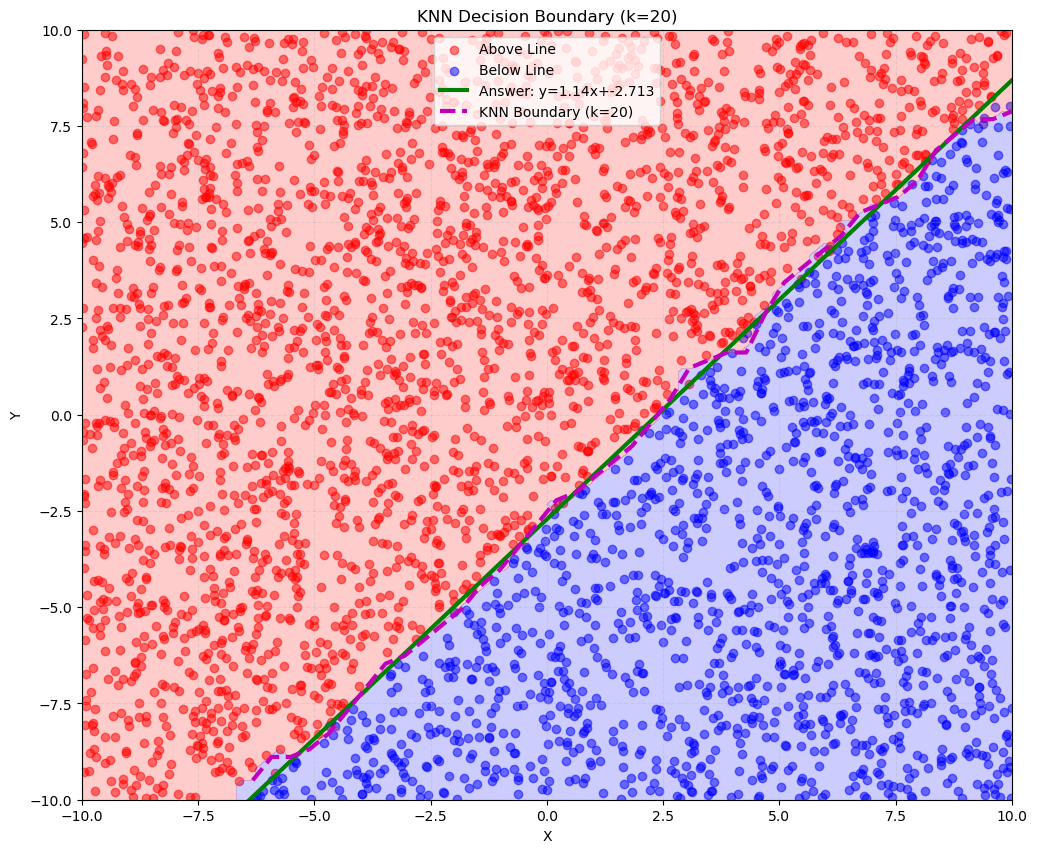

In [184]:
plot_decision_boundary(a, b, best_model, train_data, train_labels)

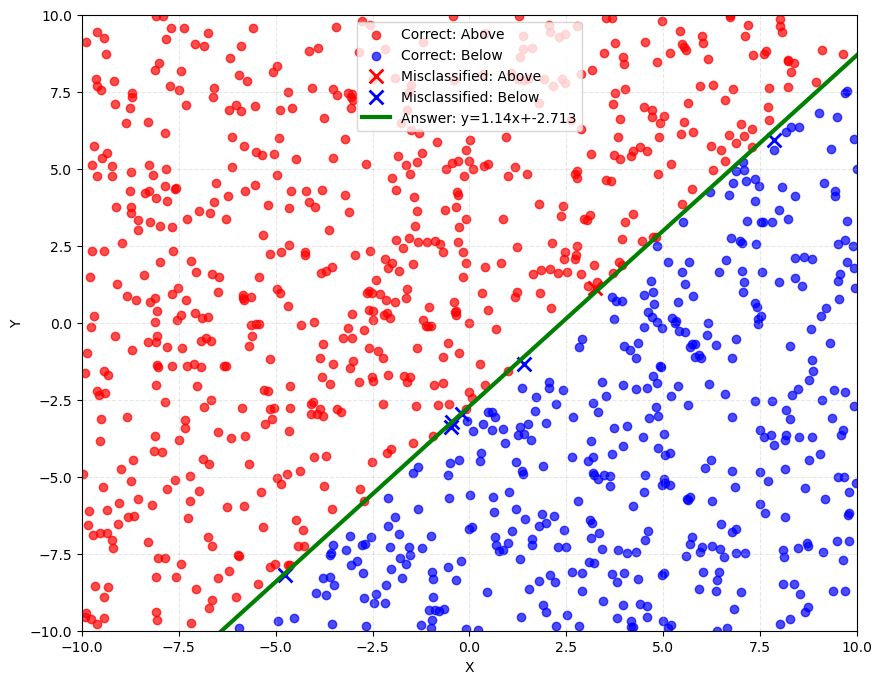

In [185]:
# 可视化测试集结果
plt.figure(figsize=(10, 8))

# 绘制测试点，使用不同形状表示预测是否正确
correct_indices = (test_preds == test_labels)
incorrect_indices = ~correct_indices

# 正确分类的点
correct_points = test_data[correct_indices]
correct_labels = test_labels[correct_indices]
correct_red = correct_points[correct_labels == 1]
correct_blue = correct_points[correct_labels == 0]

# 错误分类的点
incorrect_points = test_data[incorrect_indices]
incorrect_labels = test_labels[incorrect_indices]
incorrect_red = incorrect_points[incorrect_labels == 1]  # 实际是红色但被错分
incorrect_blue = incorrect_points[incorrect_labels == 0]  # 实际是蓝色但被错分

# 绘制正确分类的点
plt.scatter(correct_red[:, 0], correct_red[:, 1], color='red', marker='o', alpha=0.7, label='Correct: Above')
plt.scatter(correct_blue[:, 0], correct_blue[:, 1], color='blue', marker='o', alpha=0.7, label='Correct: Below')

# 绘制错误分类的点
plt.scatter(incorrect_red[:, 0], incorrect_red[:, 1], color='red', marker='x', s=100, linewidth=2, label='Misclassified: Above')
plt.scatter(incorrect_blue[:, 0], incorrect_blue[:, 1], color='blue', marker='x', s=100, linewidth=2, label='Misclassified: Below')

# 绘制答案直线
x_line = torch.linspace(-10, 10, 100)
y_line = a * x_line + b
plt.plot(x_line, y_line, 'g-', linewidth=3, label=f'Answer: y={a}x+{b}')

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.show()